# Analysing some stuff just related to draft picks

Check the percentage of draft picks, per round, that go on to play more than 50 games.  
To compensate for changing numbers of rounds and teams over time, I will not go round by round, but instead bin players into groups of 30. Each bin will be ranked 1-N.  
For players in more recent years (i.e. maybe 2015 onwards, we can take this with a grain of salt, or pause after 2015)  
So 2015 will be the final year of data for this analysis  


In [21]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [22]:
# load draft data
drafts = {}
for f in os.listdir("drafts"):
    if f not in ['2016.csv', '2017.csv', '2018.csv']:
        drafts[f.split(".")[0]] = pd.read_csv("drafts\{}".format(f))

In [23]:
# this draft data has no bins for rounds. We will need to add this in bins of 30
# each year, we need to cut the rounds off based on how many teams there are - just divide the year by rounds
# 90, 91: 12. 92, 93, 94: 11. 95, 96, 97, 98, 99, 00, 01, 02, 03, 04: 9. 05-on: 7

# career - True or False - if player played more than 50 games, consider career = True. Otherwise False

bin_size = 30

for k, v in drafts.items():
    v['Bin'] = 0
    v['Career'] = False
    counter = 0
    new_bin = 1
    for row in v.itertuples():
        v.at[row[0], 'Bin'] = new_bin
        if v.at[row[0], 'GP'] > 50:
            v.at[row[0], 'Career'] = True
        counter += 1
        if counter == 30:
            # reset counter after passing 30 players and increase bin
            counter = 0
            new_bin += 1

In [24]:
# concatenate all the draft dataframes
for k, v in drafts.items():
    v['Year'] = k

    
df = pd.concat(list(drafts.values()), sort=False)
df = df[df['Bin'] <= 7]

In [26]:
print(len(df))
print(df.head())
print(df.tail())

5460
   Overall                 Team         Player Nat. Pos   Age      To  \
0      1.0     Quebec Nordiques     Owen Nolan   GB  RW  18.0  2010.0   
1      2.0    Vancouver Canucks    Petr Nedved   CZ   C  18.0  2007.0   
2      3.0    Detroit Red Wings  Keith Primeau   CA   C  18.0  2006.0   
3      4.0  Philadelphia Flyers     Mike Ricci   CA   C  18.0  2007.0   
4      5.0  Pittsburgh Penguins   Jaromir Jagr   CZ  RW  18.0  2018.0   

           Amateur Team      GP      G  ...  GP.1   W   L  T/O  SV%  GAA  \
0        Cornwall (OHL)  1200.0  422.0  ...   NaN NaN NaN  NaN  NaN  NaN   
1         Seattle (WHL)   982.0  310.0  ...   NaN NaN NaN  NaN  NaN  NaN   
2   Niagara Falls (OHL)   909.0  266.0  ...   NaN NaN NaN  NaN  NaN  NaN   
3    Peterborough (OHL)  1099.0  243.0  ...   NaN NaN NaN  NaN  NaN  NaN   
4  Poldi Kladno (Czech)  1733.0  766.0  ...   NaN NaN NaN  NaN  NaN  NaN   

      PS  Bin  Career  Year  
0   91.6    1    True  1990  
1   65.1    1    True  1990  
2   63.4 

In [27]:
# analysis of players in bins. What is the percent chance that each bin will play more than 50 games in the NHL
# what is that percentage YoY
# discount values from Season 2016+
#df.groupby(['Career']).agg("count")
print(df.Career.value_counts())
print(4561 / len(df))
print(1845/len(df))

False    3748
True     1712
Name: Career, dtype: int64
0.8353479853479854
0.33791208791208793


In [28]:
years = list(range(2005, 2016)) # excludes 2016
years = [str(y) for y in years]
df05_15 = df[df.Year.isin(years)] #  & df['Year'] <= 2015

print(df05_15.Career.value_counts())
print(1663 / len(df05_15))
print(679 /len(df05_15))

False    1635
True      675
Name: Career, dtype: int64
0.71991341991342
0.29393939393939394


In [29]:
#grouped_df = df.groupby(['Bin', 'Career']).size().to_frame()
grouped_ser = pd.DataFrame(df.groupby(['Bin', 'Career']).size())

grouped_ser.reset_index(inplace=True)

# fuck it maked a new dataframe
# grouped_df = pd.DataFrame()
# grouped_df['Bin'] = 0
# grouped_df['Career'] = False
# grouped_df['Count'] = 0
# grouped_df['GroupTotal'] = 0
# grouped_df['Pct'] = 0.0

rows = []
cur_bin = 0

for row in grouped_ser.itertuples():

    # each bin should repeat, so for each value, we first check if bin is equal to previous bin
    new_bin = row[1]
    cur_car = row[2]
    cur_cnt = row[3]
    ind = row[0]
    
    if new_bin != cur_bin:
        # new bin grouping
        cur_bin = new_bin
        row_dict = {'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': 0, 'Pct': 0.0}
        rows.append(row_dict)
    else:
        cur_bin = cur_bin
        tot = cur_cnt + rows[ind - 1]['Count']
        pct = cur_cnt / tot
        row_dict = {'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': tot, 'Pct': pct}
        rows.append(row_dict)
        rows[ind - 1]['GroupTotal'] = tot
        rows[ind - 1]['Pct'] = rows[ind - 1]['Count'] / tot
    

grouped_df = pd.DataFrame(rows)    
print(grouped_df)
    

    Bin  Career  Count  GroupTotal       Pct
0     1   False    172         780  0.220513
1     1    True    608         780  0.779487
2     2   False    458         780  0.587179
3     2    True    322         780  0.412821
4     3   False    535         780  0.685897
5     3    True    245         780  0.314103
6     4   False    606         780  0.776923
7     4    True    174         780  0.223077
8     5   False    637         780  0.816667
9     5    True    143         780  0.183333
10    6   False    649         780  0.832051
11    6    True    131         780  0.167949
12    7   False    691         780  0.885897
13    7    True     89         780  0.114103


In [30]:
# same but with year added
grouped_ser = pd.DataFrame(df.groupby(['Year', 'Bin', 'Career']).size())

grouped_ser.reset_index(inplace=True)

rows = []
cur_bin = 0

for row in grouped_ser.itertuples():

    # each bin should repeat, so for each value, we first check if bin is equal to previous bin
    new_yr = row[1]
    new_bin = row[2]
    cur_car = row[3]
    cur_cnt = row[4]
    ind = row[0]
    
    if new_bin != cur_bin:
        # new bin grouping
        cur_bin = new_bin
        row_dict = {'Year': new_yr, 'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': 0, 'Pct': 0.0}
        rows.append(row_dict)
    else:
        cur_bin = cur_bin
        tot = cur_cnt + rows[ind - 1]['Count']
        pct = cur_cnt / tot
        row_dict = {'Year': new_yr, 'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': tot, 'Pct': pct}
        rows.append(row_dict)
        rows[ind - 1]['GroupTotal'] = tot
        rows[ind - 1]['Pct'] = rows[ind - 1]['Count'] / tot
    

grouped_df_yr = pd.DataFrame(rows)    
print(grouped_df_yr)
    

     Year  Bin  Career  Count  GroupTotal       Pct
0    1990    1   False      8          30  0.266667
1    1990    1    True     22          30  0.733333
2    1990    2   False     19          30  0.633333
3    1990    2    True     11          30  0.366667
4    1990    3   False     17          30  0.566667
..    ...  ...     ...    ...         ...       ...
355  2015    4    True      1          30  0.033333
356  2015    5   False     30           0  0.000000
357  2015    6   False     30           0  0.000000
358  2015    7   False     29          30  0.966667
359  2015    7    True      1          30  0.033333

[360 rows x 6 columns]


             1         2         3         4         5         6         7
Year                                                                      
1990  0.733333  0.366667  0.433333  0.266667  0.200000  0.166667  0.100000
1991  0.866667  0.433333  0.333333  0.266667  0.300000  0.133333  0.100000
1992  0.766667  0.533333  0.466667  0.166667  0.233333  0.133333  0.200000
1993  0.800000  0.466667  0.366667  0.233333  0.333333  0.200000  0.133333
1994  0.900000  0.533333  0.400000  0.233333  0.200000  0.233333       NaN


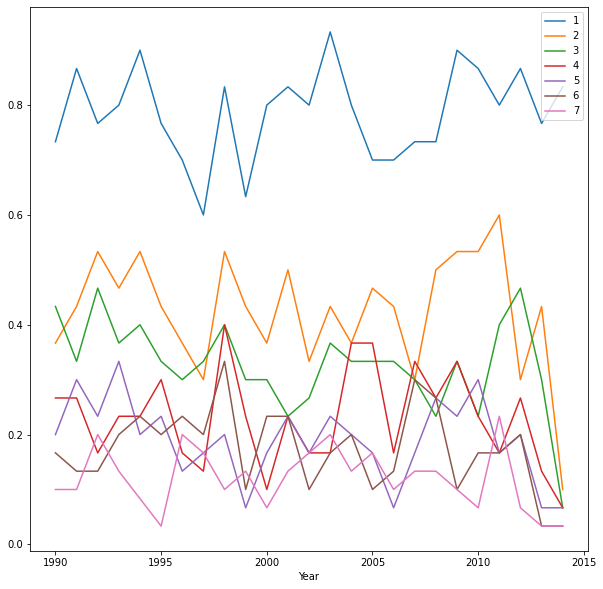

In [31]:
# if we make a "wide-form" df, we can pass that to lineplot and get all plots in 1 graph
# wide form would be index of year and columns of bin. we will keep percentage and career = True
# there will be only rows from 1990-2015, and only columns 1-N(bin)
widerows = []
years = list(range(1990, 2016))
cur_year = years[0]
cur_row = {'Year': cur_year}
# use rows from cell above
for row in rows:
    if int(row['Year']) != cur_year:
        widerows.append(cur_row)
        cur_row = {}
        cur_year += 1
        cur_row['Year'] = cur_year
        
        
        
    if row['Career'] and row['Bin'] <= 7:
        cur_row[row['Bin']] = row['Pct']


wide_df = pd.DataFrame(widerows).set_index('Year')
print(wide_df.head())

sns.lineplot(data=wide_df, dashes=False)

In [32]:
# send to csv. send both the main dataset and this version
df.to_csv(r"created_data\drafts.csv")

In [33]:
grouped_df.to_csv(r"created_data\drafts_grouping.csv")

In [34]:
grouped_df_yr.to_csv(r"created_data\drafts_grouping_year.csv")

In [35]:
pd.DataFrame({'Percentage': df.groupby(['Bin', 'Career']).size() / len(df)})

Percentage
Bin Career            
1   False     0.031502
    True      0.111355
2   False     0.083883
    True      0.058974
3   False     0.097985
    True      0.044872
4   False     0.110989
    True      0.031868
5   False     0.116667
    True      0.026190
6   False     0.118864
    True      0.023993
7   False     0.126557
    True      0.016300

### Teams

Are there some teams that are just better at drafting than others?

In [37]:
# same but with team added instead of year
grouped_ser = pd.DataFrame(df.groupby(['Team', 'Bin', 'Career']).size())

grouped_ser.reset_index(inplace=True)

rows = []
cur_bin = 0

for row in grouped_ser.itertuples():

    # each bin should repeat, so for each value, we first check if bin is equal to previous bin
    new_tm = row[1]
    new_bin = row[2]
    cur_car = row[3]
    cur_cnt = row[4]
    ind = row[0]
    
    if new_bin != cur_bin:
        # new bin grouping
        cur_bin = new_bin
        row_dict = {'Team': new_tm, 'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': 0, 'Pct': 0.0}
        rows.append(row_dict)
    else:
        cur_bin = cur_bin
        tot = cur_cnt + rows[ind - 1]['Count']
        pct = cur_cnt / tot
        row_dict = {'Team': new_tm, 'Bin': cur_bin, 'Career': cur_car, 'Count': cur_cnt, 'GroupTotal': tot, 'Pct': pct}
        rows.append(row_dict)
        rows[ind - 1]['GroupTotal'] = tot
        rows[ind - 1]['Pct'] = rows[ind - 1]['Count'] / tot
    

grouped_df_tm = pd.DataFrame(rows)    
print(grouped_df_tm)
    

              Team  Bin  Career  Count  GroupTotal       Pct
0    Anaheim Ducks    1   False      5          28  0.178571
1    Anaheim Ducks    1    True     23          28  0.821429
2    Anaheim Ducks    2   False     10          25  0.400000
3    Anaheim Ducks    2    True     15          25  0.600000
4    Anaheim Ducks    3   False     19          24  0.791667
..             ...  ...     ...    ...         ...       ...
468  Winnipeg Jets    5   False      9          11  0.818182
469  Winnipeg Jets    5    True      2          11  0.181818
470  Winnipeg Jets    6   False     10           0  0.000000
471  Winnipeg Jets    7   False     13          16  0.812500
472  Winnipeg Jets    7    True      3          16  0.187500

[473 rows x 6 columns]


In [38]:
print(grouped_df_tm[grouped_df_tm['Team']=='Ottawa Senators'])

                Team  Bin  Career  Count  GroupTotal       Pct
307  Ottawa Senators    1   False      4          30  0.133333
308  Ottawa Senators    1    True     26          30  0.866667
309  Ottawa Senators    2   False     10          18  0.555556
310  Ottawa Senators    2    True      8          18  0.444444
311  Ottawa Senators    3   False     19          24  0.791667
312  Ottawa Senators    3    True      5          24  0.208333
313  Ottawa Senators    4   False     14          25  0.560000
314  Ottawa Senators    4    True     11          25  0.440000
315  Ottawa Senators    5   False     20          26  0.769231
316  Ottawa Senators    5    True      6          26  0.230769
317  Ottawa Senators    6   False     17          22  0.772727
318  Ottawa Senators    6    True      5          22  0.227273
319  Ottawa Senators    7   False     22          25  0.880000
320  Ottawa Senators    7    True      3          25  0.120000


In [39]:
teams = {}
team_years = []
for row in grouped_df_tm.itertuples():
    if row[1] in list(teams.keys()):
        count += row[4]
        if row[3]:
            players += row[4]
    else:
        teams[row[1]] = 0.0
        count = row[4]
        players = 0
        # only keep the True careers
        if row[3]:
            players = row[4]
        
    
    # calculate new percentage every time
    print("Calculating percentage for {} with players={} and count={}".format(row[1], players, count))
    teams[row[1]] = players / count
    
    
    
sorted_teams = sorted(teams.items(), key=lambda x: x[1], reverse=True)
print(sorted_teams)

Calculating percentage for Anaheim Ducks with players=0 and count=5
Calculating percentage for Anaheim Ducks with players=23 and count=28
Calculating percentage for Anaheim Ducks with players=23 and count=38
Calculating percentage for Anaheim Ducks with players=38 and count=53
Calculating percentage for Anaheim Ducks with players=38 and count=72
Calculating percentage for Anaheim Ducks with players=43 and count=77
Calculating percentage for Anaheim Ducks with players=43 and count=92
Calculating percentage for Anaheim Ducks with players=48 and count=97
Calculating percentage for Anaheim Ducks with players=48 and count=114
Calculating percentage for Anaheim Ducks with players=53 and count=119
Calculating percentage for Anaheim Ducks with players=53 and count=138
Calculating percentage for Anaheim Ducks with players=54 and count=139
Calculating percentage for Anaheim Ducks with players=54 and count=152
Calculating percentage for Anaheim Ducks with players=56 and count=154
Calculating perc

In [40]:
# sorted_teams to dataframe then csv
df_team_pct = pd.DataFrame(sorted_teams, columns=['Team', 'Pct'])
df_team_pct.to_csv((r"created_data\team_pct.csv"))